In [56]:
import csv
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
import collections
import mglearn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
import itertools
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [57]:
%matplotlib inline

### Reading the CSV file and cleaning

feature dataframe has the features read except for the first (seq_num) and the last column (label)
The dataframe also drop the Glucose column and replaces all NaN values and 7,9 (in labels) to 0

Features were also normalized - (features - features.mean())/features.std()

In [58]:
df = pd.read_csv('../Data/new_nhanes.csv')
df = df.iloc[:, 1:]

# replace string values with integers
df['Gender'] = df['Gender'].map({'female': 1, 'male': 0})
df['Diabetes'] = df['Diabetes'].map({'Yes': 1, 'No': 0})

# dropping all NaN in the dataframe
df = df.dropna(axis=0, how='any')

print "Cleaned label counts:"
print df.groupby('Diabetes').size()

#separating features and labels
features = df.iloc[:, 0:-1]
label = df.iloc[:,-1]

print "\n"
print "Columns in the features"
column_names = list(features)
print column_names
# #normalizing features - unnormalized also results in similar results
normalized_features = (features - features.mean())/features.std()

Cleaned label counts:
Diabetes
0.0    6987
1.0     648
dtype: int64


Columns in the features
['Gender', 'Age', 'BMI', 'Weight', 'Height', 'TotChol', 'BPSys1', 'BPDia1']


#### Pair Plot of Normalized Features - Red Diabetic, Blue Normal

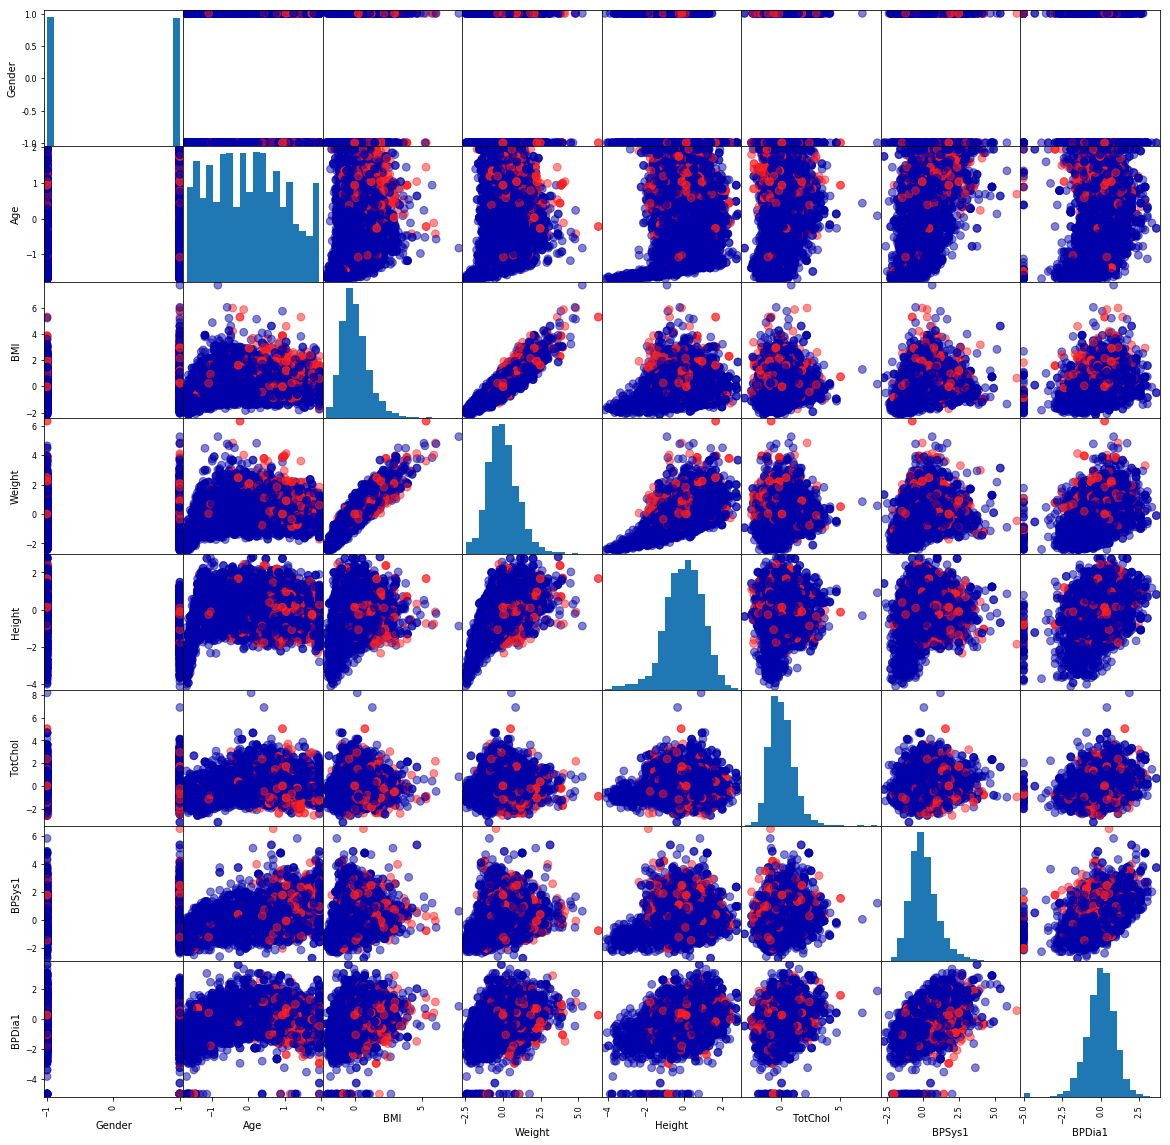

In [59]:
# create a scatter matrix from the dataframe, color by y
grr = pd.scatter_matrix(normalized_features, c=label, figsize=(20, 20), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.5, cmap=mglearn.cm2)

In [60]:
train = df.sample(frac=0.8,random_state=200)
test = df.drop(train.index)
print "Training Data"
print train.groupby('Diabetes').size()
print "Testing Data"
print test.groupby('Diabetes').size()

Training Data
Diabetes
0.0    5588
1.0     520
dtype: int64
Testing Data
Diabetes
0.0    1399
1.0     128
dtype: int64


In [61]:
#Training Data 20 sub-samples balanced (close)
X_train_list = []
Y_train_list = []
for i in xrange(0,20):
    df1 = train[train.Diabetes == 0].sample(frac=0.1) #normal data
    df2 = train[train.Diabetes == 1]
    sdf = pd.concat([df1,df2])
    #separating features and labels
    features = sdf.iloc[:, 0:-1]
    label = sdf.iloc[:,-1]
    X_train_list.append(features.as_matrix())
    Y_train_list.append(label.as_matrix())

# Testing Data
test_features = test.iloc[:, 0:-1]
test_labels = test.iloc[:,-1]
X_test = test_features.as_matrix()
Y_test = test_labels.as_matrix()

### Machine Learning

In [62]:
def generate_rf(X_train, y_train,num_estimators):
    clf = RandomForestClassifier(n_estimators=num_estimators, max_features=None)
    clf.fit(X_train, y_train)
    return clf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

In [63]:
#multiple rfs
print "training"
rfs = []
for i in xrange(0,20):
    rf = generate_rf(X_train_list[i], Y_train_list[i], 500)
    rfs.append(rf)

print "training done"

print "predicting with test data"
predicted = []

for rf in rfs:
    p_label = rf.predict(X_test)
    predicted.append(p_label)
print "Done with predction"

training
training done
predicting with test data
Done with predction


In [64]:
np_predicted = np.vstack(predicted)

np_predicted = np.transpose(np_predicted)

predicted_label = []
for each in np_predicted:
    uniqw, inverse = np.unique(each, return_inverse=True)
    counts = np.bincount(inverse)
    predicted_label.append(np.argmax(counts))
predicted_label = np.asarray(predicted_label)

             precision    recall  f1-score   support

     Normal       0.92      0.80      0.86      1399
   Diabetic       0.09      0.21      0.13       128

avg / total       0.85      0.75      0.80      1527

Confusion matrix, without normalization
[[1125  274]
 [ 101   27]]


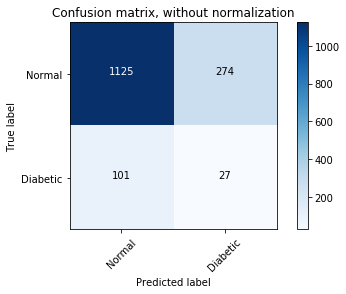

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


target_names = ['Normal', 'Diabetic']

print(classification_report(Y_test, predicted_label, target_names=target_names))

cnf_matrix = confusion_matrix(Y_test, predicted_label)
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')